# Create an end to end machine learning workflow using Amazon Athena
Importing and transforming data can be one of the most challenging tasks in a machine learning workflow. We provide you with a Jupyter notebook that demonstrates a cost-effective strategy for an extract, transform, and load (ETL) workflow. Using Amazon Simple Storage Service (Amazon S3) and Amazon Athena, you learn how to query and transform data from a Jupyter notebook. Amazon S3 is an object storage service that allows you to store data and machine learning artifacts. Amazon Athena enables you to interactively query the data stored in those buckets, saving each query as a CSV file in an Amazon S3 location.

The tutorial imports 16 CSV files for the 2019 NYC taxi dataset from multiple Amazon S3 locations. The goal is to predict the fare amount for each ride. From these 16 files, the notebook creates a single ride fare dataset and a single ride info dataset with deduplicated values. We join the deduplicated datasets into a single dataset.

Amazon Athena stores the query results as a CSV file in the specified location. We provide the output to a SageMaker Processing Job to split the data into training, validation, and test sets. While data can be split using queries, a processing job ensures that the data is in a format that's parseable by the XGBoost algorithm.

__Prerequisites:__

The notebook must be run in the us-east-1 AWS Region. You also need your own Amazon S3 bucket and a database within Amazon Athena. You won't be able to access the data used in the tutorial otherwise.

For information about creating a bucket, see [Creating a bucket](https://docs.aws.amazon.com/AmazonS3/latest/userguide/create-bucket-overview.html). For information about creating a database, see [Create a database](https://docs.aws.amazon.com/athena/latest/ug/getting-started.html#step-1-create-a-database).

Amazon Athena uses the AWS Glue Data Catalog to read the data from Amazon S3 into a database. You must have permissions to use Glue. To clean up, you also need permissions to delete the bucket you've created. For a quick guide to providing permissions, see [Setting up
](http://parsash-clouddesk-2024.aka.corp.amazon.com/sagemaker-dg/src/AWSIronmanApiDoc/build/server-root/sagemaker/latest/dg/create-end-to-end-ml-workflow-athena.html#setting-up).

## Solution overview

To create the end to end workflow, we do the following:

1. Create an Amazon Athena client within the us-east-1 AWS Region.
2. Define the run_athena_query function that runs queries and prints out the status in the following cell.
3. Create the `ride_fare` table within your database using all ride fare tables for the year 2019.
4. Create the `ride_info` table using ride info table for the year 2019.
5. Create the `ride_info_deduped` and `ride_fare_deduped` tables that have all duplicate values removed from the original tables.
6. Run test queries to get the first ten rows of each table to see whether they have data.
7. Define the `get_query_results` function that takes the query ID and returns comma separated values that can be stored as a dataframe.
8. View the results of the test queries within pandas dataframes.
9. Join the `ride_info_deduped` and `ride_fare_deduped` tables into the `combined_ride_data_deduped` table.
10. Select all values in the combined table.
11. Define the `get_csv_file_location` function to get the Amazon S3 location of the query results.
12. Download the CSV file to our environment.
13. Perform Exploratory Data Analysis (EDA) on the data.
14. Use the results of the EDA to select the relevant features in query.
15. Use the `get_csv_file_location` function to get the location of those query results.
16. Split the data into training, validation, and test sets using a processing job.
17. Download the test dataset.
18. Take a 20 row sample from the test dataset.
20. Create a dataframe with 20 rows of actual and predicted values.
21. Calculate the RMSE of the data.
22. Clean up the resources created within the notebook.

### Define the run_athena_query function

In the following cell, we define the `run_athena_query` function. It runs an Athena query and waits for its completion.

It takes the following arguments:

-       query_string (str): The SQL query to be executed.
-       database_name (str): The name of the Athena database.
-       output_location (str): The S3 location where the query results are stored.


It returns the query execution ID string.

In [1]:
# Import required libraries
import time
import boto3

def run_athena_query(query_string, database_name, output_location):
    # Create an Athena client
    athena_client = boto3.client('athena', region_name='us-east-1')

    # Start the query execution
    response = athena_client.start_query_execution(
        QueryString=query_string,
        QueryExecutionContext={'Database': database_name},
        ResultConfiguration={'OutputLocation': output_location}
    )

    query_execution_id = response['QueryExecutionId']
    print(f"Query execution ID: {query_execution_id}")

    while True:
        # Check the query execution status
        query_status = athena_client.get_query_execution(QueryExecutionId=query_execution_id)
        state = query_status['QueryExecution']['Status']['State']

        if state == 'SUCCEEDED':
            print("Query executed successfully.")
            break
        elif state == 'FAILED':
            print(f"Query failed with error: {query_status['QueryExecution']['Status']['StateChangeReason']}")
            break
        else:
            print(f"Query is currently in {state} state. Waiting for completion...")
            time.sleep(5)  # Wait for 5 seconds before checking again

    return query_execution_id


### Create the ride_fare table

We've provided you with the query. You most provide the name of the database you created within Amazon Athena and the Amazon S3 output location. If you're not sure about how to specify the output location, provide the name of the S3 bucket. After running the query, you should get a message that says "Query executed successfully." and a 36 character string in single quotes.

In [3]:
# SQL query to create the 'ride_fare' table
create_ride_fare_table = """
CREATE EXTERNAL TABLE `ride_fare` (
  `ride_id` bigint, 
  `payment_type` smallint, 
  `fare_amount` float, 
  `extra` float, 
  `mta_tax` float, 
  `tip_amount` float, 
  `tolls_amount` float, 
  `total_amount` float
)
ROW FORMAT DELIMITED 
  FIELDS TERMINATED BY ',' 
  LINES TERMINATED BY '\n' 
STORED AS INPUTFORMAT 
  'org.apache.hadoop.mapred.TextInputFormat' 
OUTPUTFORMAT 
  'org.apache.hadoop.hive.ql.io.HiveIgnoreKeyTextOutputFormat'
LOCATION
  's3://dsoaws/nyc-taxi-orig-cleaned-split-csv-with-header-per-year-multiple-files/ride-fare/year=2019'
TBLPROPERTIES (
  'skip.header.line.count'='1', 
  'transient_lastDdlTime'='1716908234'
);
"""

# Athena database name
database = 'example-database-name'

# S3 location for query results
s3_output_location = 's3://example-s3-bucket/example-s3-prefix'

# Execute the query to create the 'ride_fare' table
run_athena_query(create_ride_fare_table, database, s3_output_location)

Query execution ID: cb929408-df15-408d-a776-a8963facbf80
Query is currently in QUEUED state. Waiting for completion...
Query executed successfully.


'cb929408-df15-408d-a776-a8963facbf80'

### Create the ride fare table with the duplicates removed

In [4]:
# SQL query to create a new table with duplicates removed
remove_duplicates_from_ride_fare = """
CREATE TABLE ride_fare_deduped
AS
SELECT DISTINCT *
FROM ride_fare
"""

# Run the preceding query
run_athena_query(remove_duplicates_from_ride_fare, database, s3_output_location)

Query execution ID: 15337c2c-54e5-4e19-94a8-92d2faef2efd
Query is currently in QUEUED state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query executed successfully.


'15337c2c-54e5-4e19-94a8-92d2faef2efd'

### Create the ride_info table

In [5]:
# SQL query to create the ride_info table
create_ride_info_table_query = """
CREATE EXTERNAL TABLE `ride_info` (
  `ride_id` bigint, 
  `vendor_id` smallint, 
  `passenger_count` smallint, 
  `pickup_at` string, 
  `dropoff_at` string, 
  `trip_distance` float, 
  `rate_code_id` int, 
  `store_and_fwd_flag` string
)
ROW FORMAT DELIMITED 
  FIELDS TERMINATED BY ',' 
  LINES TERMINATED BY '\n' 
STORED AS INPUTFORMAT 
  'org.apache.hadoop.mapred.TextInputFormat' 
OUTPUTFORMAT 
  'org.apache.hadoop.hive.ql.io.HiveIgnoreKeyTextOutputFormat'
LOCATION
  's3://dsoaws/nyc-taxi-orig-cleaned-split-csv-with-header-per-year-multiple-files/ride-info/year=2019'
TBLPROPERTIES (
  'skip.header.line.count'='1', 
  'transient_lastDdlTime'='1716907328'
);
"""

# Run the query to create the ride_info table
run_athena_query(create_ride_info_table_query, database, s3_output_location)

Query execution ID: bc365d36-bbbb-4f33-a153-3192127a1069
Query is currently in QUEUED state. Waiting for completion...
Query executed successfully.


'bc365d36-bbbb-4f33-a153-3192127a1069'

### Create the ride info table with the duplicates removed

In [6]:
# SQL query to create table with duplicates removed
remove_duplicates_from_ride_info = """
CREATE TABLE ride_info_deduped
AS
SELECT DISTINCT *
FROM ride_info
"""

# Run the query to create the table with the duplicates removed
run_athena_query(remove_duplicates_from_ride_info, database, s3_output_location)

Query execution ID: 1946c89d-d1c3-449d-b7af-42521778c51c
Query is currently in QUEUED state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query executed successfully.


'1946c89d-d1c3-449d-b7af-42521778c51c'

### Run a test query on ride_info_deduped

In [7]:
test_ride_info_query = '''
SELECT * FROM ride_info_deduped limit 10
'''

run_athena_query(test_ride_info_query, database, s3_output_location)

Query execution ID: ab1e6968-e04c-47c0-94c7-03868d1d7fc1
Query is currently in QUEUED state. Waiting for completion...
Query executed successfully.


'ab1e6968-e04c-47c0-94c7-03868d1d7fc1'

### Run a test query on ride_fare_deduped

In [8]:
test_ride_fare_query = '''
SELECT * FROM ride_fare_deduped limit 10
'''

run_athena_query(test_ride_fare_query, database, s3_output_location)

Query execution ID: caeedc97-8f55-4759-9380-8ced39fab414
Query is currently in QUEUED state. Waiting for completion...
Query executed successfully.


'caeedc97-8f55-4759-9380-8ced39fab414'

### Define the `get_query_results` function

In the following cell, we define the `get_query_results` function to get the query results in CSV format. The function gets the 36 character query execution ID string. The end of the output of the preceding cell is an example of a query execution ID string.

In [9]:
import io
def get_query_results(query_execution_id):
    athena_client = boto3.client('athena', region_name='us-east-1')
    s3 = boto3.client('s3')

    # Get the query execution details
    query_execution = athena_client.get_query_execution(QueryExecutionId=query_execution_id)
    s3_location = query_execution['QueryExecution']['ResultConfiguration']['OutputLocation']

    # Extract bucket and key from S3 output location
    bucket_name, key = s3_location.split('/', 2)[2].split('/', 1)

    # Get the CSV file location
    obj = s3.get_object(Bucket=bucket_name, Key=key)
    csv_data = obj['Body'].read().decode('utf-8')
    csv_buffer = io.StringIO(csv_data)

    return csv_buffer

### Read `ride_info_deduped` test query into a dataframe

Specify the query execution ID string in the `get_query_results` function. The output is the head of the dataframe. 

In [12]:
import pandas as pd
# Provide the query execution id of the test_ride_info query to get the query results
ride_info_sample = get_query_results('test_ride_info_query_execution_id')

df_ride_info_sample = pd.read_csv(ride_info_sample)

df_ride_info_sample.head()

,ride_id,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount
0,2834679627591,1,52.0,0.0,0.5,12.28,6.12,73.70
1,1400160739953,1,52.0,2.5,0.5,11.05,0.00,66.35
2,2834679627600,2,7.0,0.0,0.5,0.00,0.00,7.80
3,1331440950394,1,4.0,1.0,0.5,1.66,0.00,9.96
4,2834679627624,1,4.5,0.0,0.5,1.06,0.00,6.36


### Read `ride_fare_deduped` test query into a dataframe

Specify the query execution ID string in the `get_query_results` function. The output is the head of the resulting dataframe. 

In [13]:
# Provide the query execution id of the test_ride_fare query to get the query results

ride_fare_sample = get_query_results('test_ride_fare_query_execution_id')

df_ride_fare_sample = pd.read_csv(ride_fare_sample)

df_ride_fare_sample.head()

,ride_id,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount
0,2834679627591,1,52.0,0.0,0.5,12.28,6.12,73.70
1,1400160739953,1,52.0,2.5,0.5,11.05,0.00,66.35
2,2834679627600,2,7.0,0.0,0.5,0.00,0.00,7.80
3,1331440950394,1,4.0,1.0,0.5,1.66,0.00,9.96
4,2834679627624,1,4.5,0.0,0.5,1.06,0.00,6.36


### Join the deduplicated tables together

In [14]:
# SQL query to join the tables into a single table containing all the data.
create_ride_joined_deduped = """
CREATE TABLE combined_ride_data_deduped AS
SELECT 
    rfs.ride_id, 
    rfs.payment_type, 
    rfs.fare_amount, 
    rfs.extra, 
    rfs.mta_tax, 
    rfs.tip_amount, 
    rfs.tolls_amount, 
    rfs.total_amount,
    ris.vendor_id, 
    ris.passenger_count, 
    ris.pickup_at, 
    ris.dropoff_at, 
    ris.trip_distance, 
    ris.rate_code_id, 
    ris.store_and_fwd_flag
FROM 
    ride_fare_deduped rfs
JOIN 
    ride_info_deduped ris
ON 
    rfs.ride_id = ris.ride_id;
;
"""

# Run the query to create the ride_data_deduped table
run_athena_query(create_ride_joined_deduped, database, s3_output_location)

Query execution ID: 8eb61f36-2e1b-43c7-9b33-61e7ce5d21bc
Query is currently in QUEUED state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query executed successfully.


'8eb61f36-2e1b-43c7-9b33-61e7ce5d21bc'

### Select all values from the deduplicated table

In [15]:
# SQL query to select all values from the table and create the dataset that we're using for our analysis
ride_combined_full_table_query = """
SELECT * FROM combined_ride_data_deduped
"""

# Run the query to select all values from the combined_ride_data_deduped table
run_athena_query(ride_combined_full_table_query, database, s3_output_location)

Query execution ID: f303cff8-5369-409a-9c51-8c791d446fe3
Query is currently in QUEUED state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...

'f303cff8-5369-409a-9c51-8c791d446fe3'

### Define get_csv_file_location function and get Amazon S3 location of query results

Specify the query ID from the preceding cell in the function call. The output is the Amazon S3 URI of the dataset. 

In [16]:
# Function to get the Amazon S3 URI location of Amazon Athena select statements
def get_csv_file_location(query_execution_id):
    athena_client = boto3.client('athena', region_name='us-east-1')
    query_execution = athena_client.get_query_execution(QueryExecutionId=query_execution_id)
    s3_location = query_execution['QueryExecution']['ResultConfiguration']['OutputLocation']

    return s3_location

# Provide the 36 character string at the end of the output of the preceding cell as the query.
get_csv_file_location('ride_combined_full_table_query_execution_id')

's3://ux360-nyc-taxi-dogfooding/f303cff8-5369-409a-9c51-8c791d446fe3.csv'

### Download the dataset and rename it

Replace the example S3 path in the following cell with the output of the preceding cell. The second command renames the CSV file it downloads to `nyc-taxi-whole-dataset.csv`.

In [17]:
# Use the S3 URI location returned from the preceding cell to download the dataset and rename it.
!aws s3 cp s3://example-s3-bucket/ride_combined_full_table_query_execution_id.csv .
!mv ride_combined_full_table_query_execution_id.csv nyc-taxi-whole-dataset.csv

download: s3://ux360-nyc-taxi-dogfooding/f303cff8-5369-409a-9c51-8c791d446fe3.csv to ./f303cff8-5369-409a-9c51-8c791d446fe3.csv
mv: cannot stat 'query-id.csv': No such file or directory


### Get a 20,000 row sample and some information about it

In [20]:
sample_nyc_taxi_combined = pd.read_csv('nyc-taxi-whole-dataset.csv', nrows=20000)

In [21]:
print("Dataset shape: ", sample_nyc_taxi_combined.shape)

Dataset shape:  (20000, 15)


In [22]:
df = sample_nyc_taxi_combined

df.head()

,ride_id,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount,vendor_id,passenger_count,pickup_at,dropoff_at,trip_distance,rate_code_id,store_and_fwd_flag
0,60131839014,1,7.5,0.0,0.5,1.66,0.0,9.96,2,1,2019-01-04T07:53:41.000Z,2019-01-04T08:02:20.000Z,1.45,1,N
1,60131839074,1,8.0,0.0,0.5,1.00,0.0,9.80,2,2,2019-01-04T07:05:28.000Z,2019-01-04T07:13:12.000Z,1.91,1,N
2,1391571568740,1,8.5,0.0,0.5,2.36,0.0,14.16,2,2,2019-02-05T10:59:56.000Z,2019-02-05T11:10:40.000Z,1.53,1,N
3,60131839130,1,8.0,0.0,0.5,1.76,0.0,10.56,2,1,2019-01-04T07:12:07.000Z,2019-01-04T07:20:07.000Z,1.68,1,N
4,1391571568912,1,5.0,0.0,0.5,1.66,0.0,9.96,2,1,2019-02-05T11:14:36.000Z,2019-02-05T11:19:52.000Z,0.65,1,N


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ride_id             20000 non-null  int64  
 1   payment_type        20000 non-null  int64  
 2   fare_amount         20000 non-null  float64
 3   extra               20000 non-null  float64
 4   mta_tax             20000 non-null  float64
 5   tip_amount          20000 non-null  float64
 6   tolls_amount        20000 non-null  float64
 7   total_amount        20000 non-null  float64
 8   vendor_id           20000 non-null  int64  
 9   passenger_count     20000 non-null  int64  
 10  pickup_at           20000 non-null  object 
 11  dropoff_at          20000 non-null  object 
 12  trip_distance       20000 non-null  float64
 13  rate_code_id        20000 non-null  int64  
 14  store_and_fwd_flag  20000 non-null  object 
dtypes: float64(7), int64(5), object(3)
memory usage: 2.3+

In [24]:
df.describe()

,ride_id,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount,vendor_id,passenger_count,trip_distance,rate_code_id
count,2.000000e+04,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.00000,20000.000000,20000.000000
mean,1.818963e+12,1.288700,12.920155,1.060540,0.496025,2.128392,0.376976,18.472139,1.62440,1.56845,2.928530,1.054400
std,1.210592e+12,0.476407,11.890878,1.230733,0.050959,2.601379,1.639528,14.664932,0.48429,1.21552,3.841776,0.363108
min,5.153977e+10,1.000000,-74.500000,-4.500000,-0.500000,0.000000,0.000000,-76.300000,1.00000,0.00000,0.000000,1.000000
25%,1.005022e+12,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,10.790000,1.00000,1.00000,0.940000,1.000000
50%,1.400160e+12,1.000000,9.000000,0.500000,0.500000,1.795000,0.000000,14.160000,2.00000,1.00000,1.600000,1.000000
75%,2.834679e+12,2.000000,14.500000,2.500000,0.500000,2.860000,0.000000,19.800000,2.00000,2.00000,3.000000,1.000000
max,3.839702e+12,4.000000,300.000000,7.000000,0.500000,52.160000,30.500000,312.960000,2.00000,6.00000,70.890000,5.000000


In [25]:
df['vendor_id'].value_counts()

vendor_id
2    12488
1     7512
Name: count, dtype: int64

In [26]:
df['passenger_count'].value_counts()

passenger_count
1    14030
2     3040
3      857
5      850
6      487
4      379
0      357
Name: count, dtype: int64

### View the distribution of fare amount values

<function matplotlib.pyplot.show(close=None, block=None)>

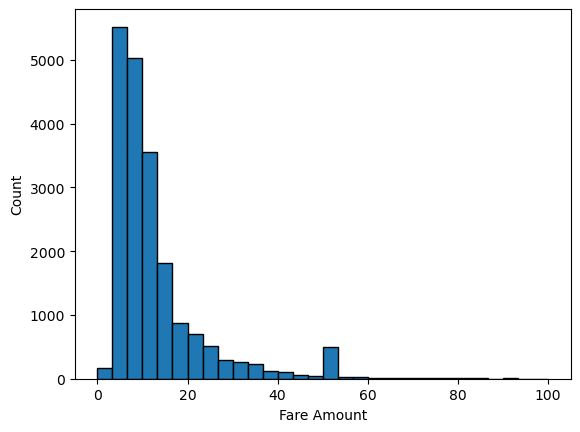

In [27]:
# Plot to find the distribution of ride fare values
import matplotlib.pyplot as plt
plt.hist(df['fare_amount'], edgecolor='black', bins=30, range=(0,100))
plt.xlabel('Fare Amount')
plt.ylabel('Count')
plt.show

### Make sure that all rows are unique

In [28]:
df['ride_id'].nunique()

20000

### Drop the store_and_fwd flag

Determining its relevance isn't in scope for this tutorial.

In [29]:
df.drop('store_and_fwd_flag', axis=1, inplace=True)

### Drop the time series columns

Analyzing the time series data also isn't in scope for this analysis.

In [30]:
# We're dropping the time series columns to streamline the analysis.
time_series_columns_to_drop = ['pickup_at','dropoff_at']
df.drop(columns=time_series_columns_to_drop, inplace=True)

### Install seaborn and create scatterplots

In [31]:
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 15.5 MB/s eta 0:00:00


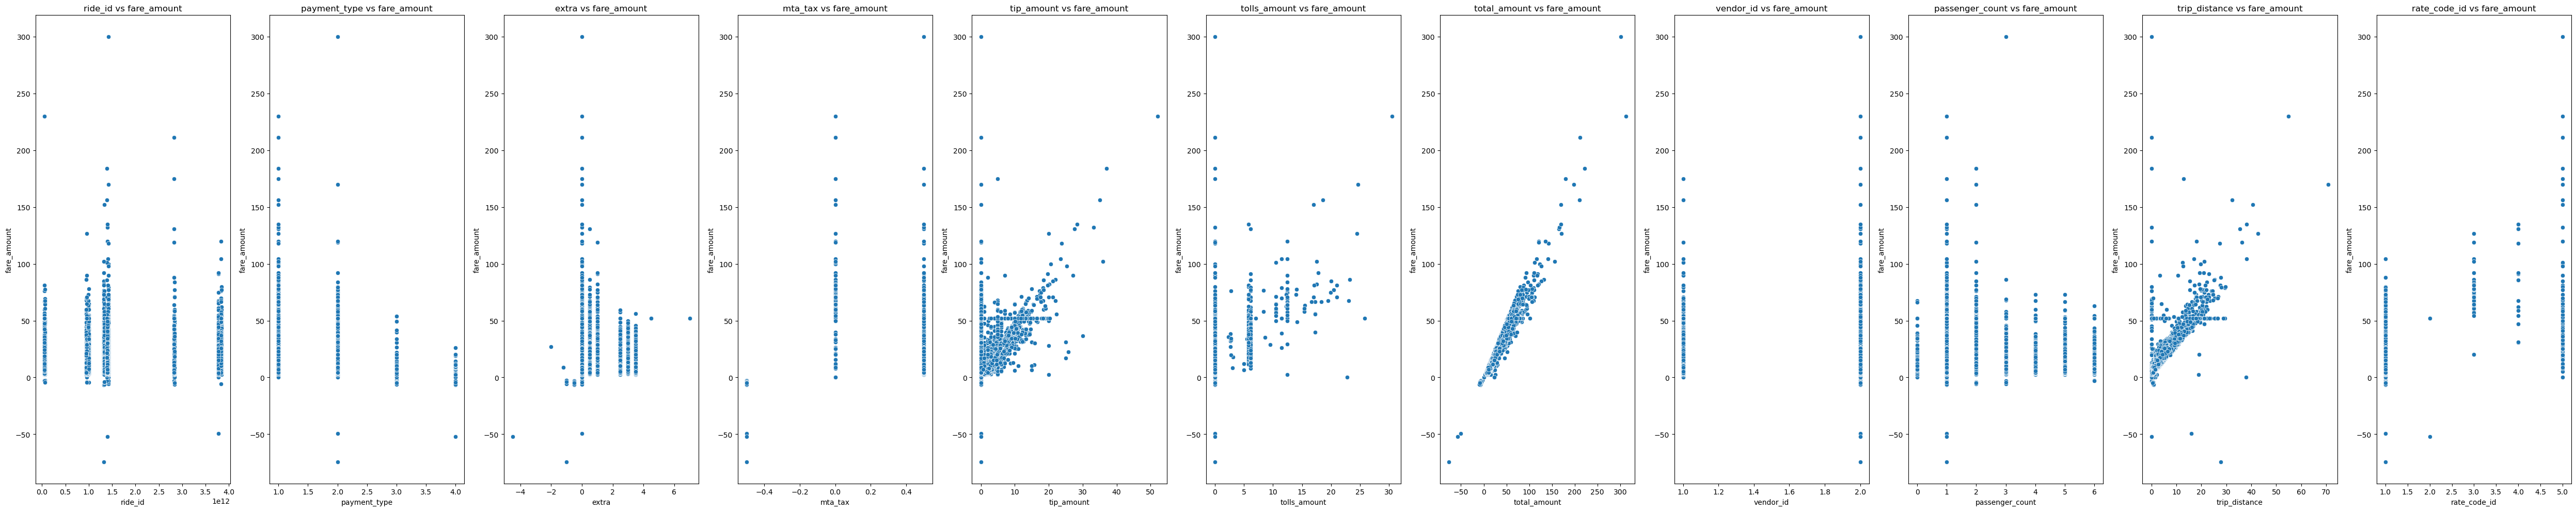

In [32]:
# Create visualizations showing correlations between variables.
import seaborn as sns
target = 'fare_amount'
features = [col for col in df.columns if col != target]

# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=len(features), figsize=(50, 10))

# Create scatter plots
for i, feature in enumerate(features):
    sns.scatterplot(x=df[feature], y=df[target], ax=axes[i])
    axes[i].set_title(f'{feature} vs {target}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel(target)

plt.tight_layout()
plt.show()

## Calculate the correlation coefficient between each feature and fare amount

In [33]:
# extra and mta_tax seem weakly correlated
# total_amount is almost perfectly correlated, indicating target leakage.
continuous_features = ['tip_amount', 'tolls_amount', 'extra', 'mta_tax', 'total_amount', 'trip_distance']

for i in continuous_features:
    correlation = df['fare_amount'].corr(df[i])
    print(i, correlation)

tip_amount 0.5743753694582684
tolls_amount 0.6327404045395644
extra -0.008246801964138361
mta_tax -0.1628089444699402
total_amount 0.9783791092253548
trip_distance 0.8848067140931489


### Calculate a one way ANOVA between the groups

From running the ANOVA, `mta_tax` and `extra` have the most variance between the groups. We're using them as features to train our model.

In [34]:
# The mta tax and extra have the most variance between the groups
from scipy.stats import f_oneway
# Separate features and target variable
X = df[['payment_type', 'extra', 'mta_tax', 'vendor_id', 'passenger_count']]
y = df['fare_amount']

# Perform one-way ANOVA for each feature
for feature in X.columns:
    groups = [y[X[feature] == group] for group in X[feature].unique()]
    if len(groups) > 1:
        f_statistic, p_value = f_oneway(*groups)
        print(f'Feature: {feature}, F-statistic: {f_statistic:.2f}, p-value: {p_value:.5f}')

Feature: payment_type, F-statistic: 22.20, p-value: 0.00000
Feature: extra, F-statistic: 130.42, p-value: 0.00000
Feature: mta_tax, F-statistic: 999.42, p-value: 0.00000
Feature: vendor_id, F-statistic: 12.42, p-value: 0.00042
Feature: passenger_count, F-statistic: 2.57, p-value: 0.01744


### Run a query to get the dataset we're using for ML workflow

The XGBoost algorithm on Amazon SageMaker uses the first column as the target column. `fare_amount` must be the first column in our query.

In [35]:
# Final select statement has tip_amount, tolls_amount, extra, mta_tax, trip_distance
ride_combined_notebook_relevant_features_query = """
SELECT fare_amount, tip_amount, tolls_amount, extra, mta_tax, trip_distance FROM combined_ride_data_deduped
"""

run_athena_query(ride_combined_notebook_relevant_features_query, database, s3_output_location)

Query execution ID: e9866ba2-8e0d-426f-a601-e6ca24890b71
Query is currently in QUEUED state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query executed successfully.


'e9866ba2-8e0d-426f-a601-e6ca24890b71'

### Get the Amazon S3 URI of the dataset

In [36]:
get_csv_file_location('ride_combined_notebook_relevant_features_query_execution_id')

's3://ux360-nyc-taxi-dogfooding/e9866ba2-8e0d-426f-a601-e6ca24890b71.csv'

### Run a SageMaker processing job to split the data

The code in `processing_data_split.py` splits the dataset into training, validation, and test sets. We use a SageMaker processing job to provide the compute needed to transform large volumes of data. For more information about processing jobs, see [Use processing jobs to run data transformation workloads](https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job.html). For more information about running sci-kit scripts, see [Data Processing with scikit-learn](https://docs.aws.amazon.com/sagemaker/latest/dg/use-scikit-learn-processing-container.html). 

For faster processing, we recommend using an `instance_count` of `2`, but you can use whatever value you prefer.

For `source` within the `ProcessingInput` function, replace `'s3://example-s3-bucket/ride_combined_notebook_relevant_features_query_execution_id.csv'` with the output of the preceding cell. Within `processing_data_split.py`, you specify `/opt/ml/processing/input/query-id` as the `input_path`. The processing job is copying the query results to a location within its own container.

For `Destination` under `ProcessingOutput`, replace `example-s3-bucket` with the Amazon S3 bucket that you've created.

In [42]:
import sagemaker
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput



# Define the SageMaker execution role
role = sagemaker.get_execution_role()

# Define the SKLearnProcessor
sklearn_processor = SKLearnProcessor(framework_version='0.20.0',
                                     role=role,
                                     instance_type='ml.m5.4xlarge',
                                     instance_count=2)

# Run the processing job
sklearn_processor.run(
    code='processing_data_split.py', 
    inputs=[ProcessingInput(
        source='s3://example-s3-bucket/ride_combined_notebook_relevant_features_query_execution_id.csv',
        destination='/opt/ml/processing/input'
    )],
    outputs=[
        ProcessingOutput(
            source='/opt/ml/processing/output/train',
            destination='s3://ux360-nyc-taxi-dogfooding/output/train'
        ),
        ProcessingOutput(
            source='/opt/ml/processing/output/validation',
            destination='s3://ux360-nyc-taxi-dogfooding/output/validation'
        ),
        ProcessingOutput(
            source='/opt/ml/processing/output/test',
            destination='s3://ux360-nyc-taxi-dogfooding/output/test'
        )
    ]
)


INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker:Creating processing-job with name sagemaker-scikit-learn-2024-06-25-17-41-19-446


.........../miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'
/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'
sys:1: DtypeWarning: Columns (0,1,2,3

### Verify that train.csv is in the location that you've specified

In [43]:
#Verify that train.csv is in the location that you've specified
!aws s3 ls s3://ux360-nyc-taxi-dogfooding/output/train/train.csv

2024-06-25 17:49:51  794185864 train.csv


### Verify that val.csv is in the location that you've specified

In [44]:
#Verify that val.csv is in the location that you've specified
!aws s3 ls s3://ux360-nyc-taxi-dogfooding/output/validation/val.csv

2024-06-25 17:49:51  170183603 val.csv


### Specify `train.csv` and `val.csv` as the input for the training job

In [45]:
from sagemaker.session import TrainingInput

bucket = 'example-s3-bucket'

train_input = TrainingInput(
    f"s3://{bucket}/output/train/train.csv", content_type="csv"
)
validation_input = TrainingInput(
    f"s3://{bucket}/output/validation/val.csv", content_type="csv"
)

### Specify the model container and output location of the model artifact

Specify the S3 location of the trained model artifact. You can access it later.

It also gets the URI of the container image. We used version `1.2-2` of the XGBoost container image, but you can specify a different version. For more information about XGBoost container images, see [Use the XGBoost algorithm with Amazon SageMaker](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html).  

In [46]:
# Getting the XGBoost container that's in us-east-1
prefix = "training-output-data"
region = "us-east-1"

from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.session import TrainingInput

s3_output_location = f's3://{bucket}/{prefix}/xgboost_model'

container = sagemaker.image_uris.retrieve("xgboost", region, "1.2-2")
print(container)

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.2-2


### Define the model

In [47]:
xgb_model = sagemaker.estimator.Estimator(
    image_uri = container,
    role = role,
    instance_count = 2,
    region = region,
    instance_type = 'ml.m5.4xlarge',
    volume_size = 5, 
    output_path = s3_output_location,
    sagemaker_session = sagemaker.Session(),
    rules = [
        Rule.sagemaker(rule_configs.create_xgboost_report()),
        ProfilerRule.sagemaker(rule_configs.ProfilerReport())
    ]
)

### Set the model hyperparameters

For the purposes of running the training job more quickly, we set the number of training rounds to 10.

In [48]:
xgb_model.set_hyperparameters(
    max_depth = 5,
    eta = 0.2,
    gamma = 4,
    min_child_weight = 6,
    subsample = 0.7,
    objective = "reg:squarederror",
    num_round = 10
)

### Train the model

In [49]:
xgb_model.fit({"train": train_input, "validation": validation_input}, wait=True)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-06-25-18-20-44-522


2024-06-25 18:20:45 Starting - Starting the training job...CreateXgboostReport: InProgress
ProfilerReport: InProgress
...
2024-06-25 18:21:29 Starting - Preparing the instances for training...
2024-06-25 18:22:09 Downloading - Downloading input data......
2024-06-25 18:23:12 Training - Training image download completed. Training in progress....[2024-06-25 18:23:33.281 ip-10-2-65-56.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-06-25:18:23:33:INFO] Imported framework sagemaker_xgboost_container.training
[2024-06-25:18:23:33:INFO] Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
[2024-06-25:18:23:33:INFO] No GPUs detected (normal if no gpus installed)
[2024-06-25:18:23:33:INFO] Running XGBoost Sagemaker in algorithm mode
[2024-06-25:18:23:33:INFO] Determined delimiter of CSV input is ','
[2024-06-25:18:23:33:INFO] Determined delimiter of CSV input is ','
[2024-06-25:18:23:33:INFO] Determined delimiter of CSV 

### Deploy the model

Copy the name of the model endpoint. We use it for our model evaluation.

In [50]:
xgb_predictor = xgb_model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-06-25-18-26-38-055
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2024-06-25-18-26-38-055
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2024-06-25-18-26-38-055


-------!

### Download the test.csv file

In [51]:
!aws s3 cp s3://example-s3-bucket/output/test/test.csv .

download: s3://ux360-nyc-taxi-dogfooding/output/test/test.csv to ./test.csv


### Create a 20 row test dataframe

In [53]:
import boto3
import json

test_df = pd.read_csv('test.csv', nrows=20)
test_df.head()

,0,1,2,3,4,5
0,7.5,1.08,0.0,0.0,0.5,0.97
1,10.0,0.00,0.0,0.5,0.5,2.60
2,6.0,1.00,0.0,1.0,0.5,0.82
3,23.5,5.45,0.0,3.0,0.5,7.40
4,53.5,8.36,10.5,0.0,0.0,12.68


### Get predictions from the test dataframe

Define the `get_predictions` function to convert the 20 row dataframe to a CSV string and get predictions from the model endpoint. Provide the `get_predictions` function with the name of the model and the model endpoint.

In [54]:
import json
import pandas as pd

# Initialize the SageMaker runtime client
runtime = boto3.client('runtime.sagemaker')

# Define the endpoint name
endpoint_name = 'sagemaker-xgboost-timestamp'

# Function to make predictions
def get_predictions(data, endpoint_name):
    # Convert the DataFrame to a CSV string and encode it to bytes
    csv_data = data.to_csv(header=False, index=False).encode('utf-8')
    
    response = runtime.invoke_endpoint(
        EndpointName=endpoint_name,
        ContentType='text/csv',
        Body=csv_data
    )
    
    # Read the response body
    response_body = response['Body'].read().decode('utf-8')
    
    try:
        # Try to parse the response as JSON
        result = json.loads(response_body)
    except json.JSONDecodeError:
        # If response is not JSON, just return the raw response
        result = response_body
        
    return result

# Drop the target column from the test dataframe
test_df = test_df.drop(test_df.columns[0], axis=1)

# Get predictions
predictions = get_predictions(test_df, endpoint_name)
print(predictions)

6.515090465545654,10.813796043395996,6.515090465545654,22.628469467163086,49.72923278808594,8.302289962768555,7.602119445800781,6.515090465545654,7.602119445800781,12.309170722961426,16.632259368896484,28.30757713317871,10.813796043395996,37.56535339355469,10.813796043395996,12.309170722961426,6.515090465545654,14.130854606628418,10.813796043395996,6.515090465545654


### Create an array from the string of predictions

In [55]:
predictions_array = predictions.split(',')
predictions_array

['6.515090465545654',
 '10.813796043395996',
 '6.515090465545654',
 '22.628469467163086',
 '49.72923278808594',
 '8.302289962768555',
 '7.602119445800781',
 '6.515090465545654',
 '7.602119445800781',
 '12.309170722961426',
 '16.632259368896484',
 '28.30757713317871',
 '10.813796043395996',
 '37.56535339355469',
 '10.813796043395996',
 '12.309170722961426',
 '6.515090465545654',
 '14.130854606628418',
 '10.813796043395996',
 '6.515090465545654']

### Get the 20 row sample of the test dataframe

In [56]:
df_with_target_column_values = pd.read_csv('test.csv', nrows=20)
df_with_target_column_values.head()

,0,1,2,3,4,5
0,7.5,1.08,0.0,0.0,0.5,0.97
1,10.0,0.00,0.0,0.5,0.5,2.60
2,6.0,1.00,0.0,1.0,0.5,0.82
3,23.5,5.45,0.0,3.0,0.5,7.40
4,53.5,8.36,10.5,0.0,0.0,12.68


### Convert the values of the predictions array from strings to floats

In [57]:
predictions_array = [float(x) for x in predictions_array]

### Create a dataframe to store the predicted versus actual values

In [58]:
comparison_df = pd.DataFrame(predictions_array, columns=['predicted_values'])
comparison_df

,predicted_values
0,6.515090
1,10.813796
2,6.515090
3,22.628469
4,49.729233
5,8.302290
6,7.602119
7,6.515090
8,7.602119
9,12.309171


### Add the actual values to the comparison dataframe

In [60]:
column_to_add = df_with_target_column_values.iloc[:, 0]

comparison_df['actual_values'] = column_to_add

comparison_df

,predicted_values,actual_values
0,6.515090,7.5
1,10.813796,10.0
2,6.515090,6.0
3,22.628469,23.5
4,49.729233,53.5
5,8.302290,9.0
6,7.602119,8.5
7,6.515090,2.5
8,7.602119,8.5
9,12.309171,17.5


### Verify that the datatypes of both columns are floats

In [61]:
comparison_df.dtypes

predicted_values    float64
actual_values       float64
dtype: object

### Compute the RMSE

In [62]:
import numpy as np

# Calculate the squared differences between the predicted and actual values
comparison_df['squared_diff'] = (comparison_df['actual_values'] - comparison_df['predicted_values']) ** 2

# Calculate the mean of the squared differences
mean_squared_diff = comparison_df['squared_diff'].mean()

# Take the square root of the mean to get the RMSE
rmse = np.sqrt(mean_squared_diff)

print(f"RMSE: {rmse}")


RMSE: 4.833823838366928


### Clean up

In [71]:
# Delete the S3 bucket
!aws s3 rb s3://example-s3-bucket --force

remove_bucket: parsa-machine-learning-exam


In [72]:
# Delete the endpoint
xgb_predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: sagemaker-xgboost-2024-06-25-18-26-38-055
INFO:sagemaker:Deleting endpoint with name: sagemaker-xgboost-2024-06-25-18-26-38-055
